Part 1: Numpy Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

1. Convolution function

In [2]:
def apply_padding(image, pad):
    if pad == 0:
        return image
    return np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)

def convolution(image, kernel, stride=1, padding=0, activation='relu', activation_params=None):
    # Get image and kernel dimensions
    (iH, iW, iC) = image.shape
    (kH, kW, kC) = kernel.shape

    # Check if kernel channels match input image channels
    if iC != kC:
        raise ValueError("Kernel channels must match input image channels.")

    # Apply padding on the image
    padded_image = apply_padding(image, padding)
    (pH, pW, _) = padded_image.shape

    # Calculate output dimensions
    oH = (pH - kH) // stride + 1
    oW = (pW - kW) // stride + 1
    output = np.zeros((oH, oW))

    # Apply the convolution operation
    for y in range(0, oH):
        for x in range(0, oW):
            region = padded_image[y*stride:y*stride+kH, x*stride:x*stride+kW]
            output[y, x] = np.sum(region * kernel)

    # Apply activation function
    if activation == 'relu':
        output = np.maximum(0, output)
    elif activation == 'sigmoid':
        output = 1 / (1 + np.exp(-output))
    elif activation == 'tanh':
        output = np.tanh(output)
    elif activation == 'prelu':
        if activation_params is None:
            raise ValueError("PReLU activation requires alpha parameter.")
        alpha = activation_params
        output = np.maximum(alpha * output, output)

    return output

2. Pooling function

In [3]:
def pooling(activation_map, pool_size=2, stride=2, pool_type='max'):
    # Get activation map dimensions
    (iH, iW) = activation_map.shape

    # Calculate output dimensions
    oH = (iH - pool_size) // stride + 1
    oW = (iW - pool_size) // stride + 1
    output = np.zeros((oH, oW))

    # Apply pooling operation on the activation map
    for y in range(0, oH):
        for x in range(0, oW):
            region = activation_map[y*stride:y*stride+pool_size, x*stride:x*stride+pool_size]
            if pool_type == 'max':
                output[y, x] = np.max(region)
            elif pool_type == 'average':
                output[y, x] = np.mean(region)

    return output

3. Convolution Layer

In [4]:
def convolution_layer(input_volume, kernels, stride=1, padding=0, activation='relu', display_output=True):

    num_kernels = len(kernels)

    # Get input volume and kernel dimensions
    (iH, iW, iC) = input_volume.shape
    (kH, kW, _) = kernels[0].shape

    # Calculate output dimensions
    oH = (iH + 2 * padding - kH) // stride + 1
    oW = (iW + 2 * padding - kW) // stride + 1

    output_volume = np.zeros((oH, oW, num_kernels))

    # Apply convolution operation for each kernel
    for i, kernel in enumerate(kernels):
        output_volume[:, :, i] = convolution(input_volume, kernel, stride, padding, activation)

    if display_output:
        # Display the input volume
        plt.figure(figsize=(5, 5))
        plt.imshow(input_volume)
        plt.title("Input Volume")
        plt.axis('off')
        plt.show()

        # Display the kernels as subplots
        plt.figure(figsize=(5, 5))
        for i in range(len(kernels)):
            plt.subplot(1, len(kernels), i + 1)
            plt.imshow(kernels[i])
            plt.title("Kernel {}".format(i + 1))
            plt.axis('off')

        # Display the output volume
        plt.figure(figsize=(5, 5))
        plt.imshow(output_volume)
        plt.title("Output Volume")
        plt.axis('off')
        plt.show()

    return output_volume

4. Pooling Layer

In [5]:
def pooling_layer(input_volume, pool_size=2, stride=2, pool_type='max'):
    # Get input volume dimensions
    (iH, iW, iC) = input_volume.shape

    # Calculate output dimensions
    oH = (iH - pool_size) // stride + 1
    oW = (iW - pool_size) // stride + 1

    pooled_volume = np.zeros((oH, oW, iC))

    # Apply pooling operation for each channel
    for c in range(iC):
        pooled_volume[:, :, c] = pooling(input_volume[:, :, c], pool_size, stride, pool_type)

    return pooled_volume

5. Flattenig Function

In [6]:
# Flatten the volume to a 1D array
def flatten(volume):
    return volume.flatten()

6. Multilayer Perceptron (MLP) function (Fully Connected)

In [7]:
def apply_nonlinearity(input_vector, weights, bias, activation='relu'):
    z = np.dot(input_vector, weights) + bias
    if activation == 'relu':
        return np.maximum(0, z)
    elif activation == 'sigmoid':
        return 1 / (1 + np.exp(-z))
    elif activation == 'tanh':
        return np.tanh(z)
    elif activation == 'softmax':
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z)
    return z

def mlp(input_vector, hidden_layers, hidden_layer_sizes, output_size, activation='relu', softmax=False):
    layers = []
    input_size = input_vector.shape[0]

    # Loop through hidden layers to do forward pass
    for size in hidden_layer_sizes:
        # Initialize weights and bias using random values
        weights = np.random.randn(input_size, size)
        bias = np.random.randn(size)

        # Apply nonlinearity to the input vector
        layer_output = apply_nonlinearity(input_vector, weights, bias, activation)
        layers.append(layer_output)

        # Update input vector and size for the next layer
        input_vector = layer_output
        input_size = size

    # Output layer
    output_weights = np.random.randn(input_size, output_size)
    output_bias = np.random.randn(output_size)
    output_vector = apply_nonlinearity(input_vector, output_weights, output_bias, activation)

    if softmax:
        exp_output = np.exp(output_vector - np.max(output_vector))
        output_vector = exp_output / np.sum(exp_output)

    return output_vector

7. CNN Feed-forward path

In [8]:
# Feed-forward path through the CNN
def cnn_feed_forward(image):
    # First Convolution Layer
    kernels_1 = [np.random.randn(5, 5, 3) for _ in range(4)]  # 4 kernels of size 5x5x3
    conv1_output = convolution_layer(image, kernels=kernels_1, stride=1, padding=2, activation='relu')

    # First Max Pooling Layer
    pool1_output = pooling_layer(conv1_output, pool_size=2, stride=2, pool_type='max')

    # Second Convolution Layer
    kernels_2 = [np.random.randn(5, 5, 4) for _ in range(4)]  # 4 kernels of size 5x5x4
    conv2_output = convolution_layer(pool1_output, kernels=kernels_2, stride=1, padding=2, activation='relu')

    # Second Max Pooling Layer
    pool2_output = pooling_layer(conv2_output, pool_size=2, stride=2, pool_type='max')

    # Flattening Layer
    flatten_output = flatten(pool2_output)

    # MLP with one hidden layer (49 nodes) and output layer (10 nodes)
    mlp_output = mlp(flatten_output, hidden_layers=1, hidden_layer_sizes=[49], output_size=10, activation='relu', softmax=True)

    return mlp_output

8. Testing with CIFAR-10 dataset

a)

In [9]:
# Load CIFAR-10 dataset
# from keras.datasets import cifar10
# (x_train, Y_train), (x_test, Y_test) = cifar10.load_data()

import torchvision
data = torchvision.datasets.CIFAR10(root='data/', download=True)

# Get numpy array of images and labels
images = np.array(data.data)
labels = np.array(data.targets)

# Shuffle the dataset
np.random.seed(0)
indices = np.arange(len(data))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Get one random image from each of the 10 classes
class_images = {}

for x, y in zip(images, labels):
    if y not in class_images:
        class_images[y] = x
    if len(class_images) == 10:
        break

Files already downloaded and verified


Image 1:, Class: 7


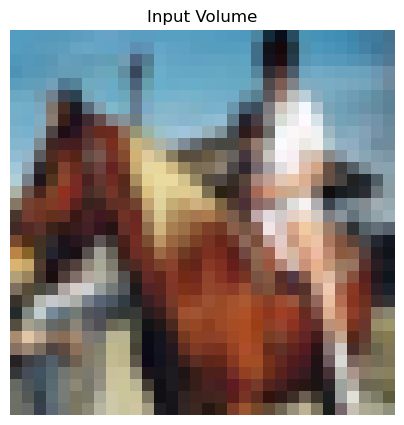

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


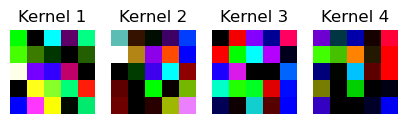

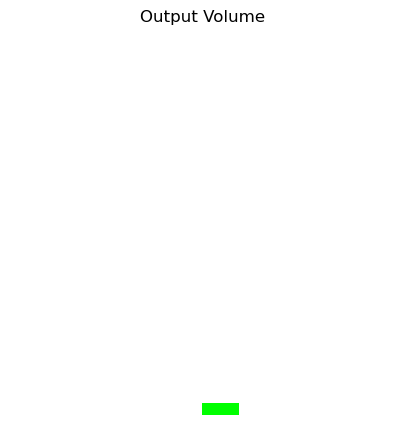

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


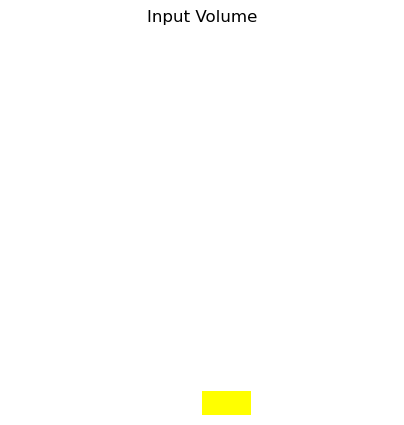

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


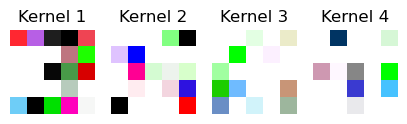

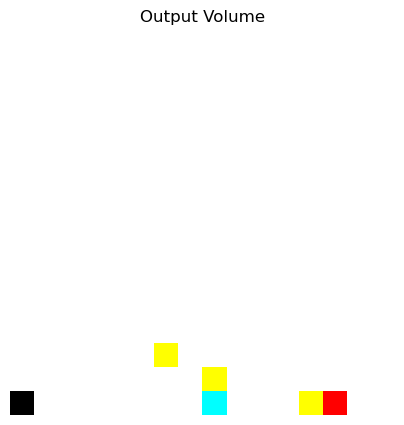

Output Vector: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Predicted Class: 8

Image 2:, Class: 5


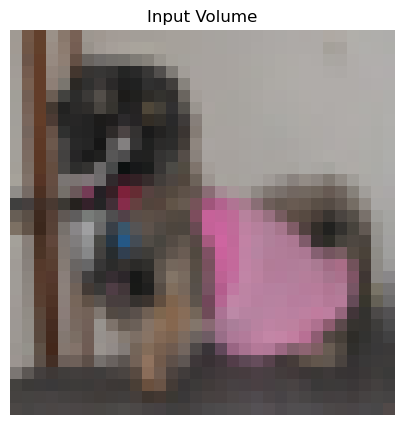

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


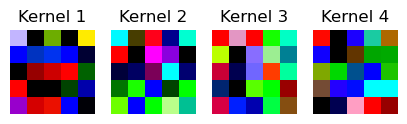

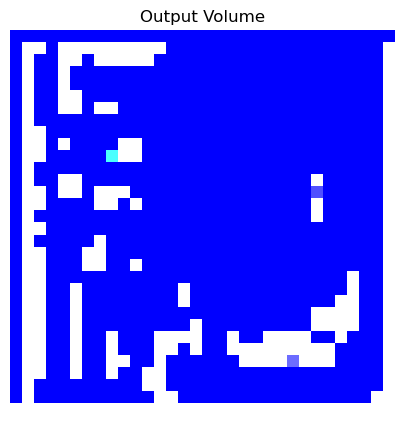

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


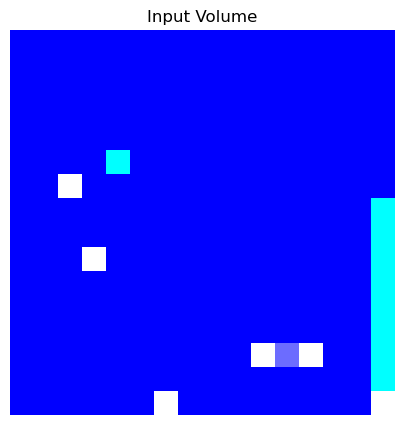

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


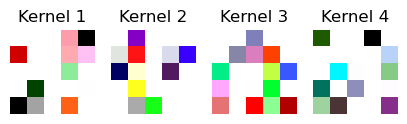

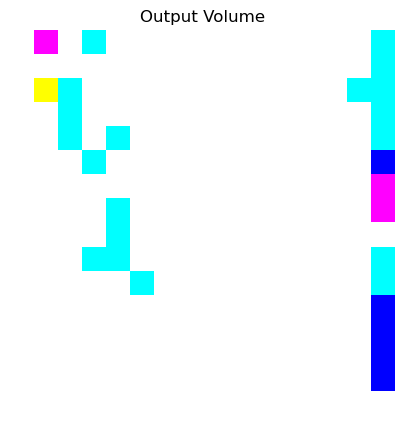

Output Vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Predicted Class: 6

Image 3:, Class: 6


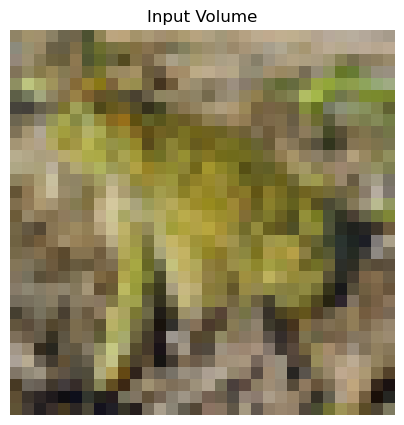

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


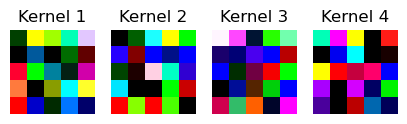

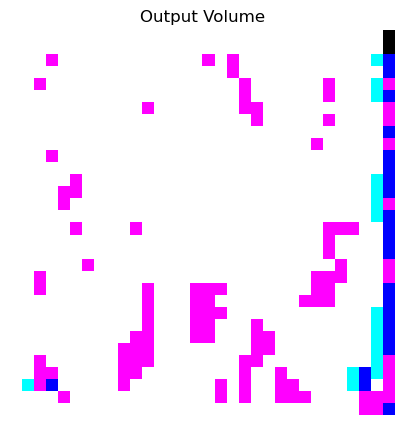

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


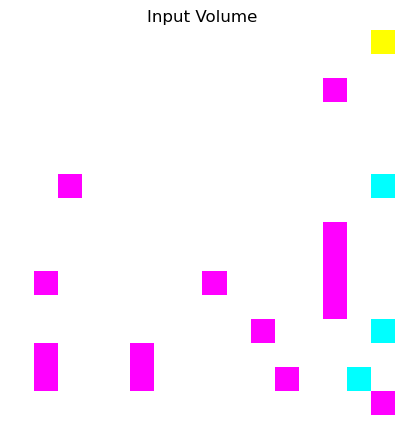

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


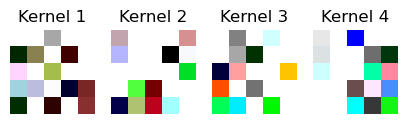

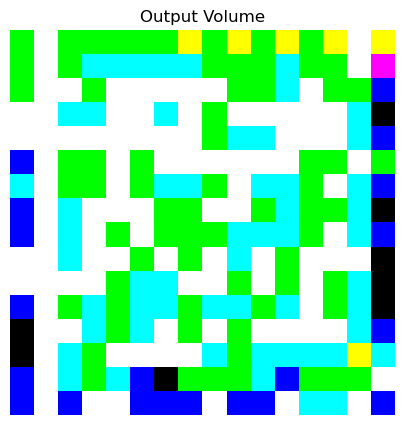

Output Vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted Class: 5

Image 4:, Class: 4


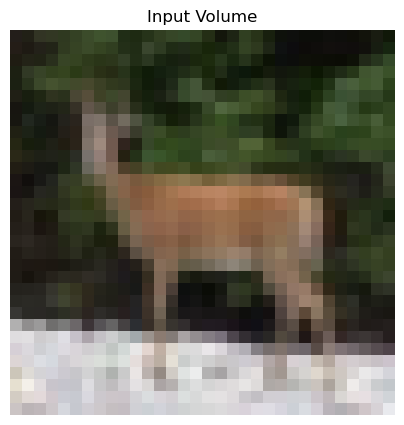

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


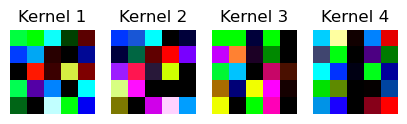

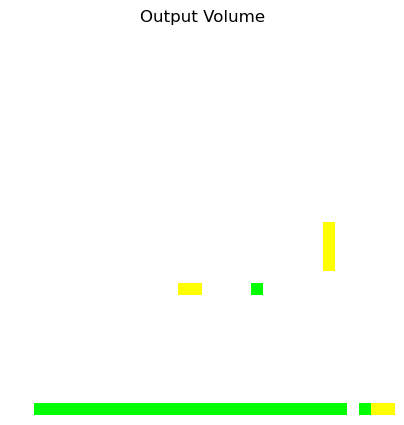

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


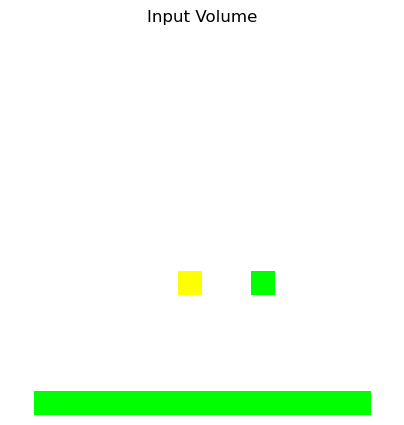

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


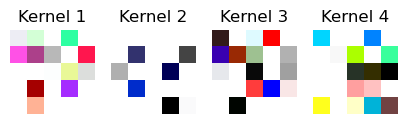

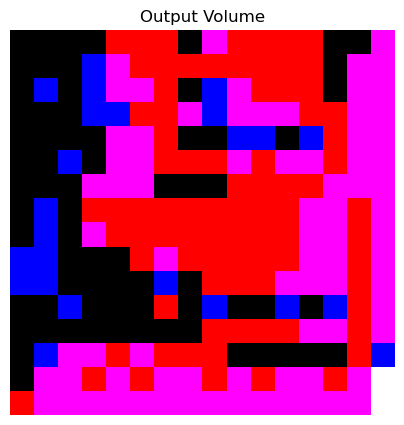

Output Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted Class: 9

Image 5:, Class: 3


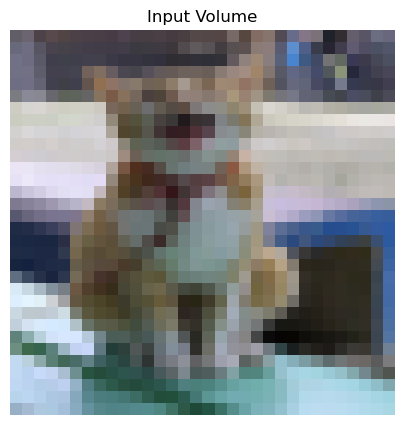

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


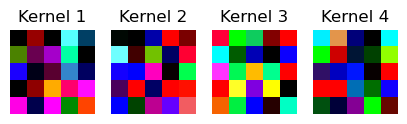

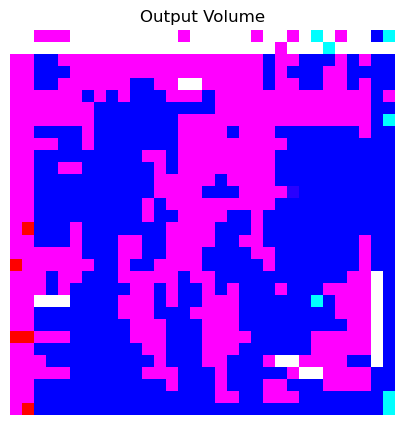

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


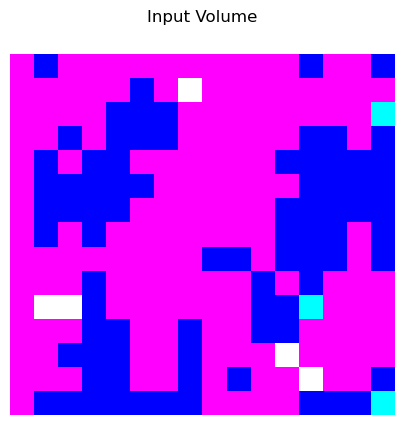

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


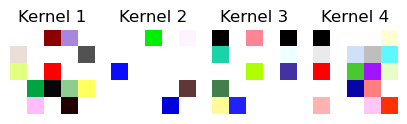

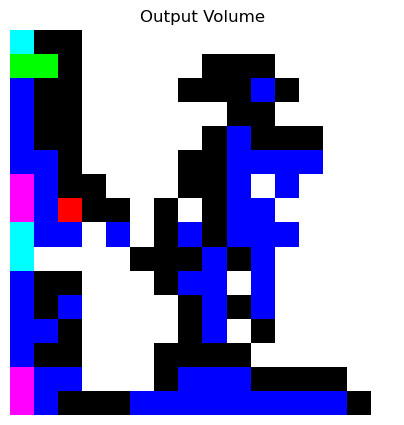

Output Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Class: 1

Image 6:, Class: 0


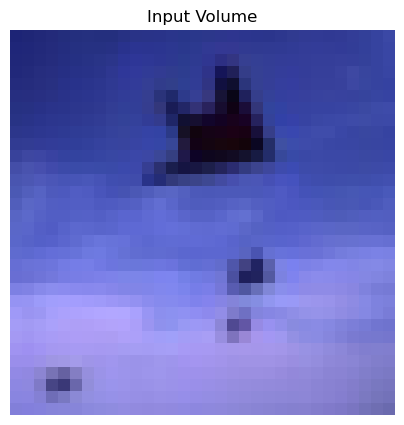

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


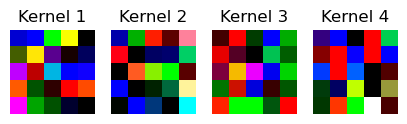

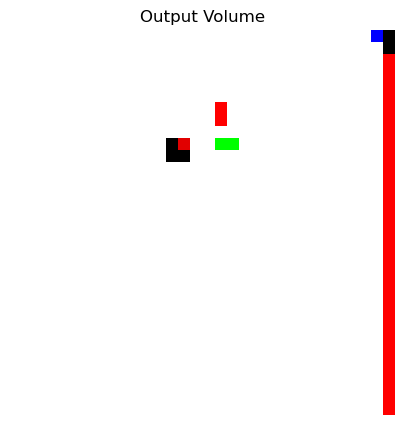

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


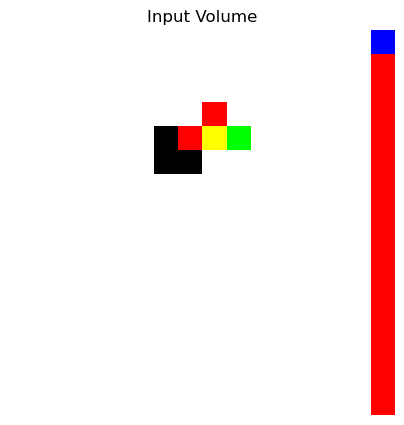

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


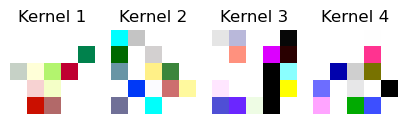

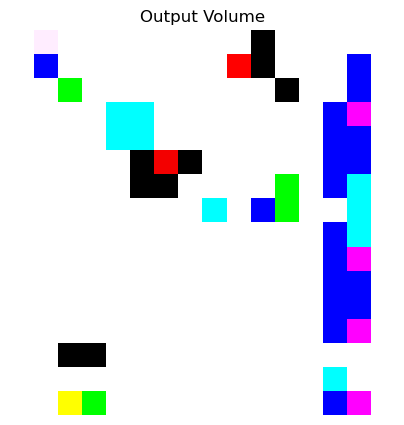

Output Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Class: 1

Image 7:, Class: 2


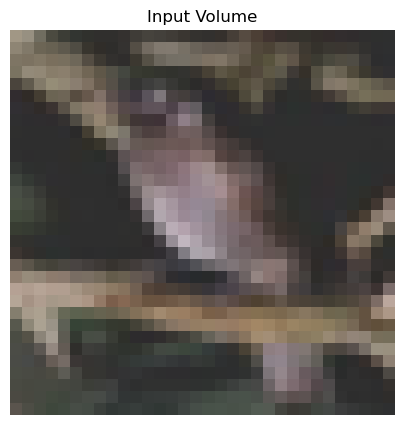

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


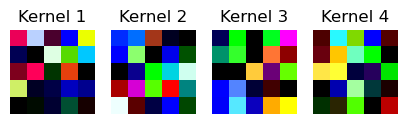

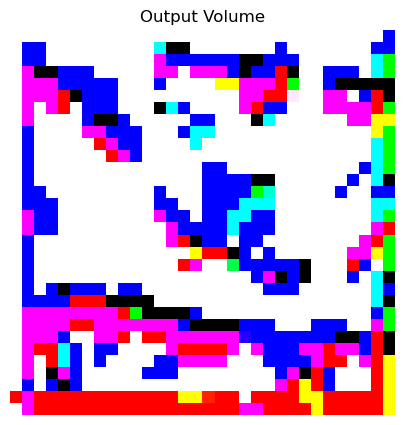

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


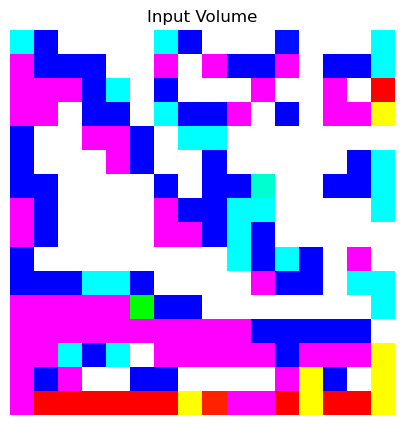

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


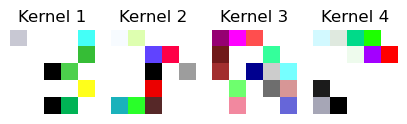

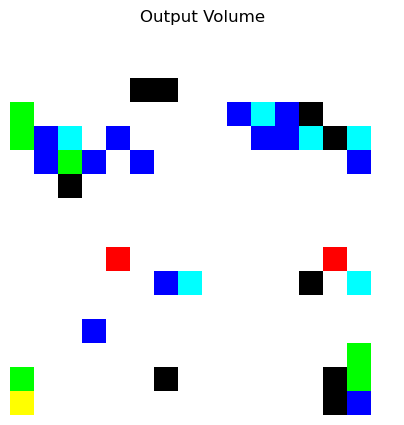

Output Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted Class: 9

Image 8:, Class: 9


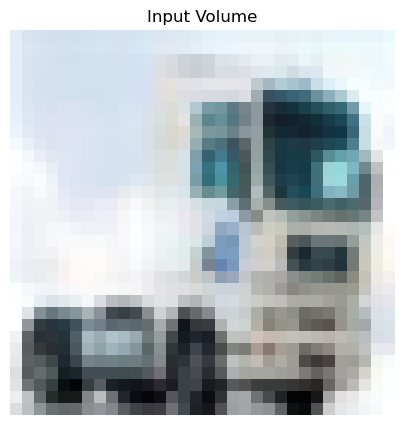

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


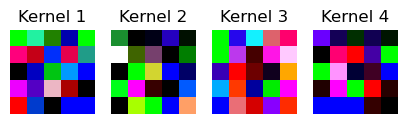

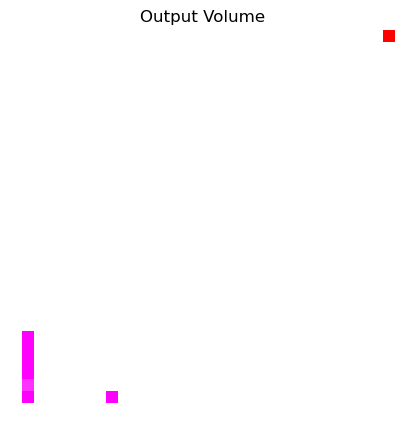

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


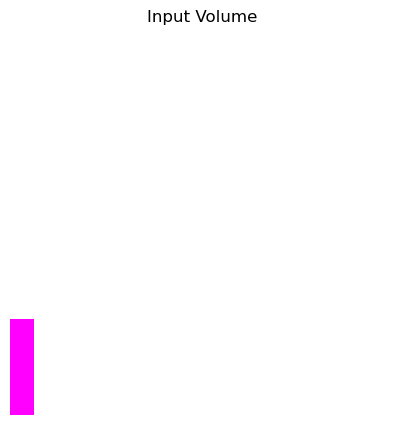

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


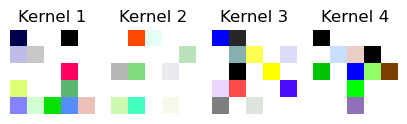

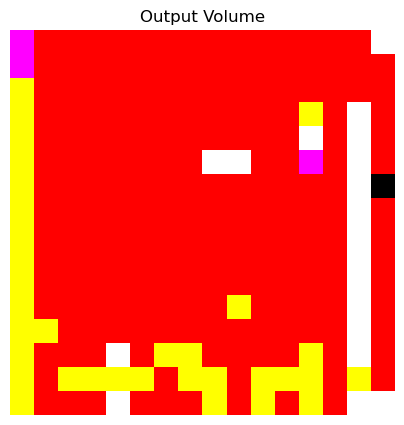

Output Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Class: 1

Image 9:, Class: 1


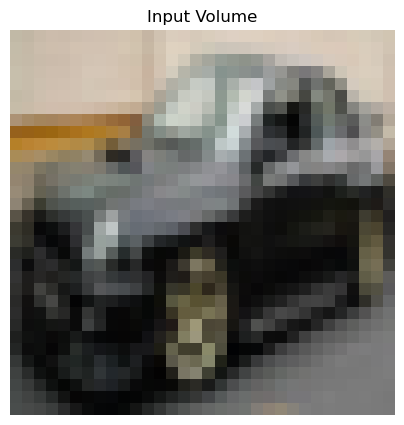

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


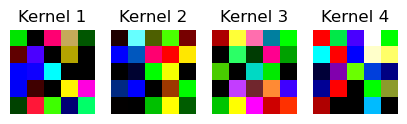

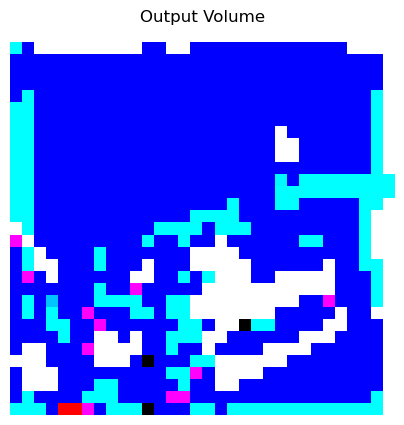

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


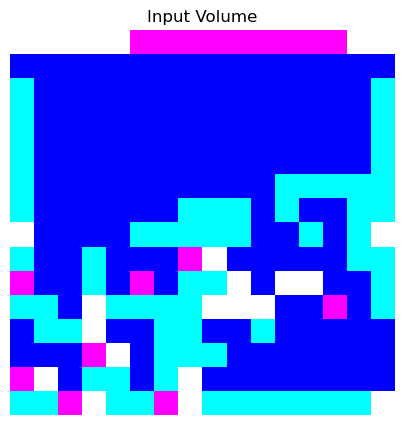

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


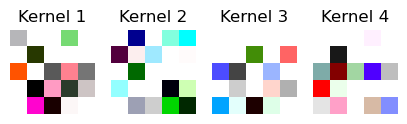

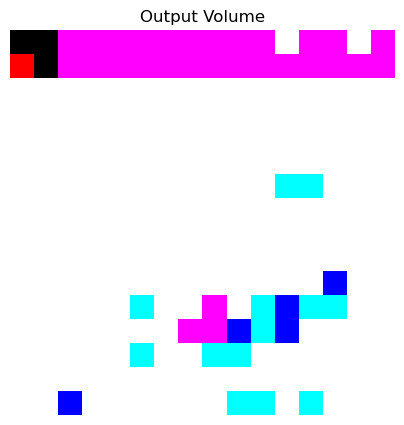

Output Vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Predicted Class: 4

Image 10:, Class: 8


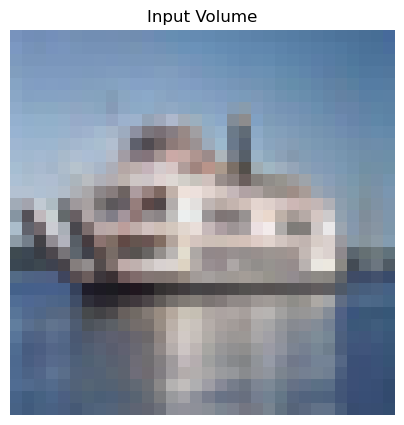

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


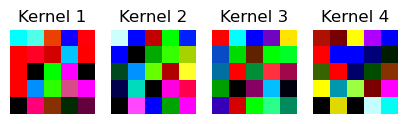

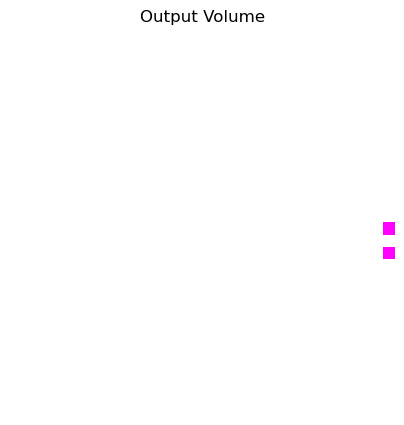

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


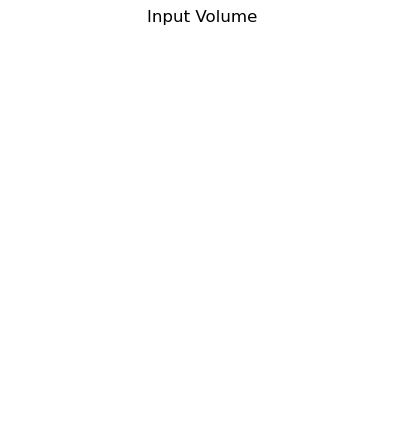

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


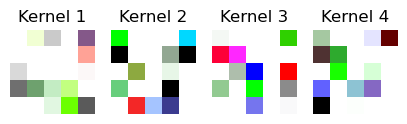

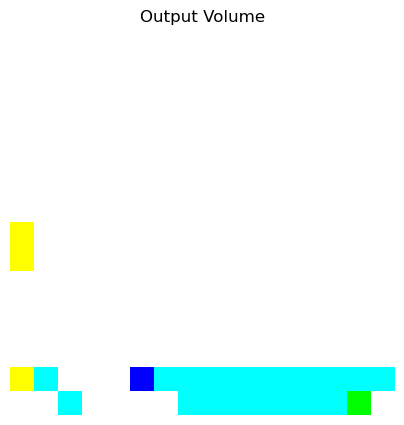

Output Vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Class: 1


In [10]:
# Choose an image from each of the 10 classes and display the output vector for each case.
for i, (y, x) in enumerate(class_images.items()):
    print(f"Image {i + 1}:, Class: {y}")
    output_vector = cnn_feed_forward(x)
    predicted_class = np.argmax(output_vector)
    print("Output Vector:", output_vector)
    print("Predicted Class:", predicted_class)
    if i != 9:
        print()

On applying softmax function to the output vector, all except one value is becoming 0. This means that with random weights, the value corresponding to one class is becoming very high and all other values are becoming very low. This trend is observed in the output of all the classes.

b)

In [11]:
# Get 3 images per class
class_images = {}

for x, y in zip(images, labels):
    if y not in class_images:
        class_images[y] = [x]
    else:
        class_images[y].append(x)
    if len(class_images) == 10 and all(len(images) == 3 for images in class_images.values()):
        break

/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


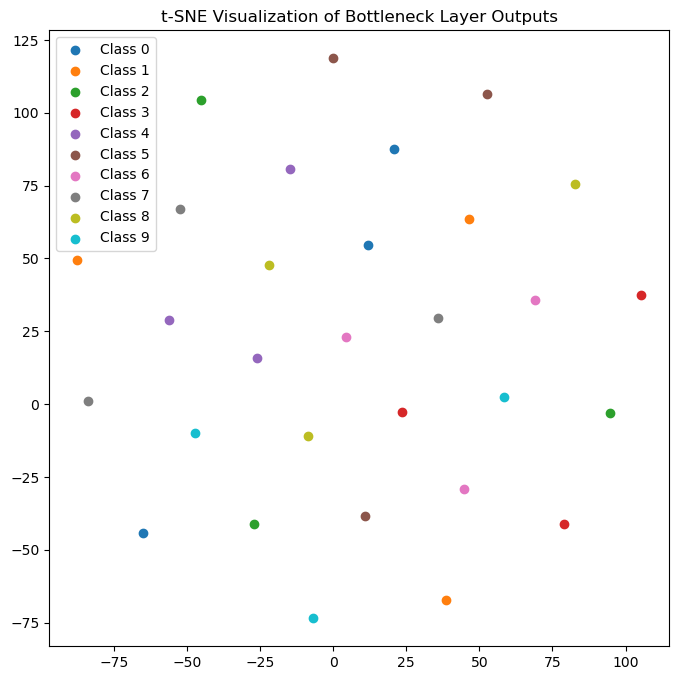

In [12]:
from sklearn.manifold import TSNE

bottleneck_outputs = []
labels = []

kernels_1 = [np.random.randn(5, 5, 3) for _ in range(4)]  # 4 kernels of size 5x5x3
kernels_2 = [np.random.randn(5, 5, 4) for _ in range(4)]  # 4 kernels of size 5x5x4

num_classes = 10
img_per_class = 3

for class_id in range(num_classes):
    for _ in range(img_per_class):
        test_image = class_images[class_id].pop()

        # Feed-forward path through the CNN
        # First Convolution Layer
        conv1_output = convolution_layer(test_image, kernels=kernels_1, stride=1, padding=2, activation='relu', display_output=False)

        # First Max Pooling Layer
        pool1_output = pooling_layer(conv1_output, pool_size=2, stride=2, pool_type='max')

        # Second Convolution Layer
        conv2_output = convolution_layer(pool1_output, kernels=kernels_2, stride=1, padding=2, activation='relu', display_output=False)

        # Second Max Pooling Layer
        pool2_output = pooling_layer(conv2_output, pool_size=2, stride=2, pool_type='max')

        # Flattening Layer, to be used as the bottleneck output
        bottleneck_output = flatten(pool2_output)
        
        bottleneck_outputs.append(bottleneck_output)
        labels.append(class_id)

# Perform t-SNE on the bottleneck outputs
bottleneck_outputs = np.array(bottleneck_outputs)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(bottleneck_outputs)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))
for class_id in range(num_classes):
    indices = [i for i, label in enumerate(labels) if label == class_id]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {class_id}')
plt.legend()
plt.title("t-SNE Visualization of Bottleneck Layer Outputs")
plt.show()


It can be seen that on using random weights, the outputs are distributed randomly and there is no proper discrimination between the classes.

Part 2: Pytorch Implementation

1, 2, 3)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Load CIFAR-10 dataset
data_tensor = torchvision.datasets.CIFAR10(root='data/',transform = torchvision.transforms.ToTensor(), download=True)

# Shuffle the dataset
np.random.seed(0)
indices = np.arange(len(data_tensor))
np.random.shuffle(indices)
data_tensor1 = []
for i in indices:
    data_tensor1.append(data_tensor[i])


# Get 100 images from each class for training and 10 images from each class for testing
class_images = {}

for x, y in data_tensor1:
    if y not in class_images:
        class_images[y] = [x]
    else:
        class_images[y].append(x)
    if all(len(images) == 110 for images in class_images.values()):
        break

# Prepare the training and testing data
X_train = torch.stack([image for images in class_images.values() for image in images[:100]])
Y_train = torch.tensor([label for label, images in class_images.items() for _ in range(100)])
X_test = torch.stack([image for images in class_images.values() for image in images[100:]])
Y_test = torch.tensor([label for label, images in class_images.items() for _ in range(10)])

Files already downloaded and verified


In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=2)

        # First Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)

        # First Fully Connected Layer with 49 nodes
        self.fc1 = nn.Linear(4 * 8 * 8, 49)

        # Output Layer with 10 nodes (for each class)
        self.fc2 = nn.Linear(49, 10)

    def forward(self, x):
        # First Convolutional Layer
        x = self.conv1(x)
        x = nn.ReLU()(x)

        # First Pooling Layer
        x = self.pool(x)

        # Second Convolutional Layer
        x = self.conv2(x)
        x = nn.ReLU()(x)

        # Second Pooling Layer
        x = self.pool(x)

        # Flatten the output volume
        x = x.view(-1, 4 * 8 * 8)

        # First Fully Connected Layer
        x = self.fc1(x)
        x = nn.ReLU()(x)

        # Output Layer, no activation function (will be applied later)
        x = self.fc2(x)

        return x

In [16]:
def accuracy(model, X_test, Y_test):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(zip(X_test, Y_test)):
            inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
            labels = torch.tensor(labels, dtype=torch.long).unsqueeze(0).reshape(1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [17]:
def visualize_activation_maps(model, input_image):
    model.eval()
    
    with torch.no_grad():
        # Pass the input through each layer to get intermediate activations
        x = torch.relu(model.conv1(input_image))
        act_map1 = x.numpy()  # First layer activations
        x = model.pool(x)
        x = torch.relu(model.conv2(x))
        act_map2 = x.numpy()  # Second layer activations
    
    # Plotting a few channels from each activation map
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(4):
        axes[0, i].imshow(act_map1[0, i], cmap='viridis')
        axes[0, i].set_title(f"Conv1 - Filter {i+1}")
        axes[1, i].imshow(act_map2[0, i], cmap='viridis')
        axes[1, i].set_title(f"Conv2 - Filter {i+1}")
    plt.show()


In [18]:
# Use CrossEntropyLoss as the loss function
criterion = nn.CrossEntropyLoss()

def train_model(model, X_train, Y_train, X_test, Y_test, optimizer, batch_size=4, num_epochs=15, display_activation_maps=True):

    errors = []

    for epoch in range(num_epochs):
        model.train()

        for i in range(0, X_train.shape[0], batch_size):

            # Get the inputs and labels for the current batch
            batch_inputs = X_train[i:i + batch_size]
            batch_labels = Y_train[i:i + batch_size]

            # Convert the inputs and labels to PyTorch tensors
            inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
            labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Shuffle the training data after each epoch
        shuffle_index = np.random.permutation(X_train.shape[0])
        X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]

        acc_test = accuracy(model, X_test, Y_test)
        acc_train = accuracy(model, X_train, Y_train)
        errors.append(1 - acc_test)

        print(f"Epoch {epoch + 1}, Train Accuracy: {acc_train:.2f}, Test Accuracy: {acc_test:.2f}")

        if display_activation_maps:
            visualize_activation_maps(model, inputs[0].unsqueeze(0))
    
    plt.figure(figsize=(5, 5))
    plt.plot(range(num_epochs), errors)
    plt.title("Test Error Rate vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Error Rate")
    plt.show()

Training with Vanilla SGD


/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.08, Test Accuracy: 0.08


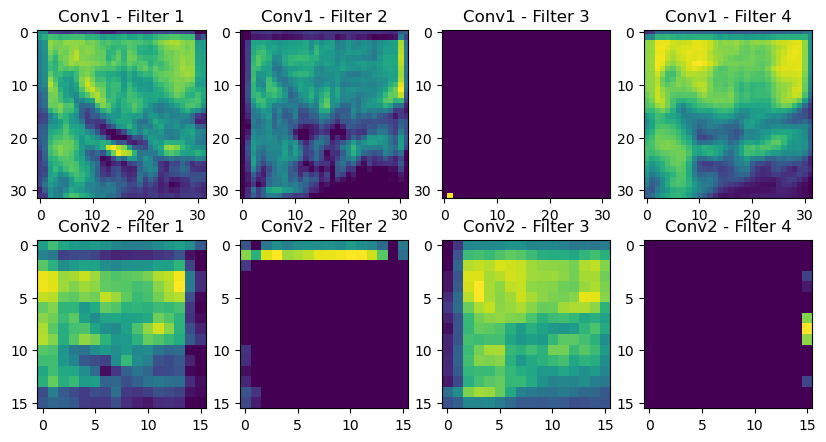

Epoch 2, Train Accuracy: 0.09, Test Accuracy: 0.08


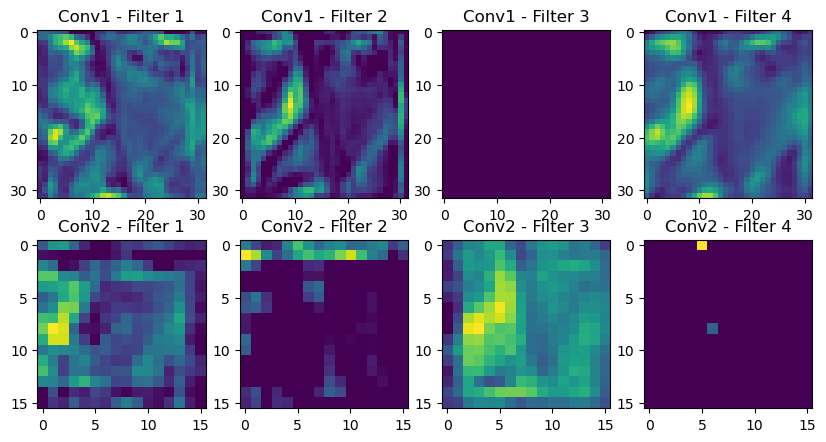

Epoch 3, Train Accuracy: 0.10, Test Accuracy: 0.08


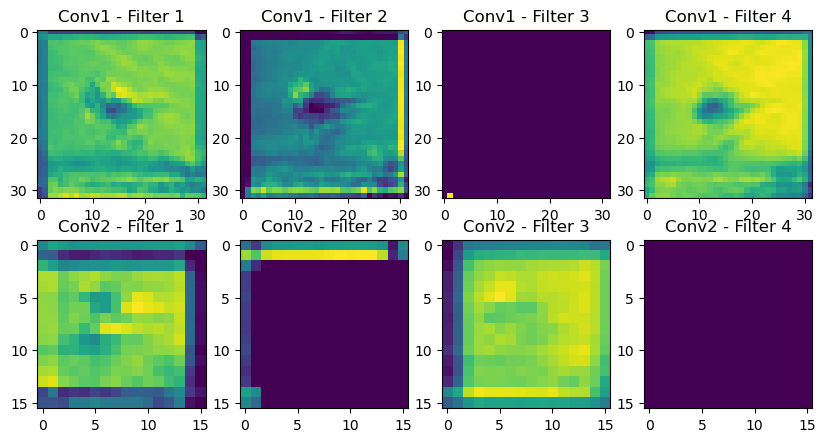

Epoch 4, Train Accuracy: 0.09, Test Accuracy: 0.09


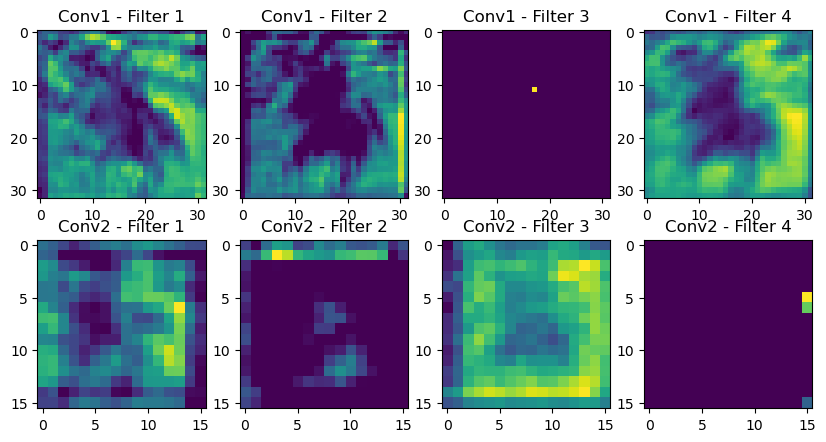

Epoch 5, Train Accuracy: 0.09, Test Accuracy: 0.09


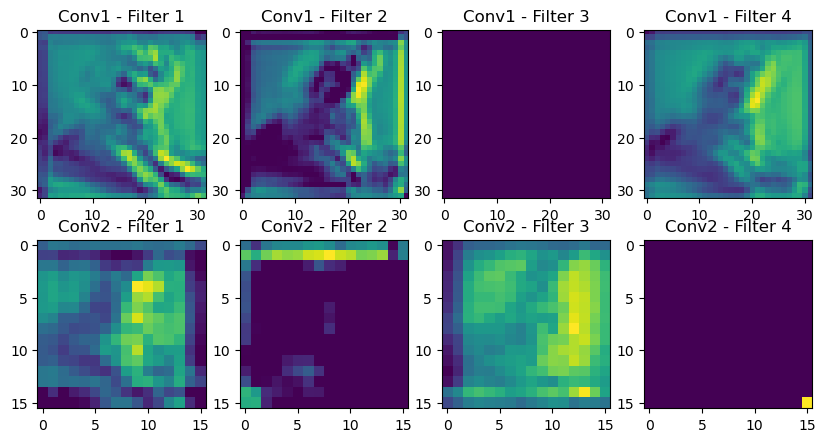

Epoch 6, Train Accuracy: 0.09, Test Accuracy: 0.09


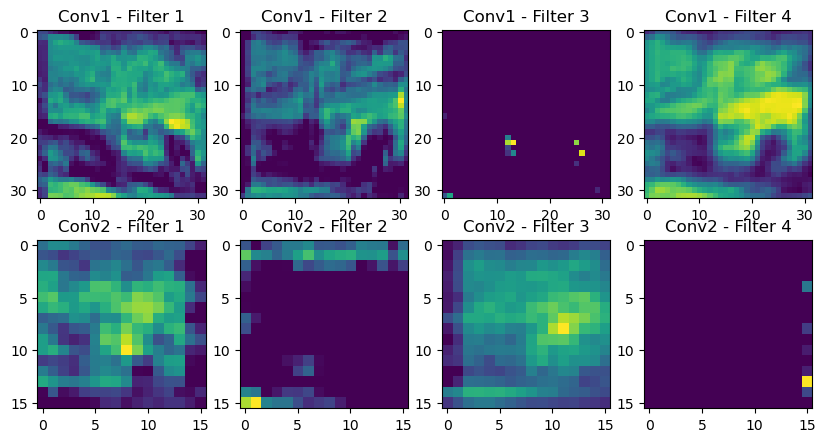

Epoch 7, Train Accuracy: 0.10, Test Accuracy: 0.09


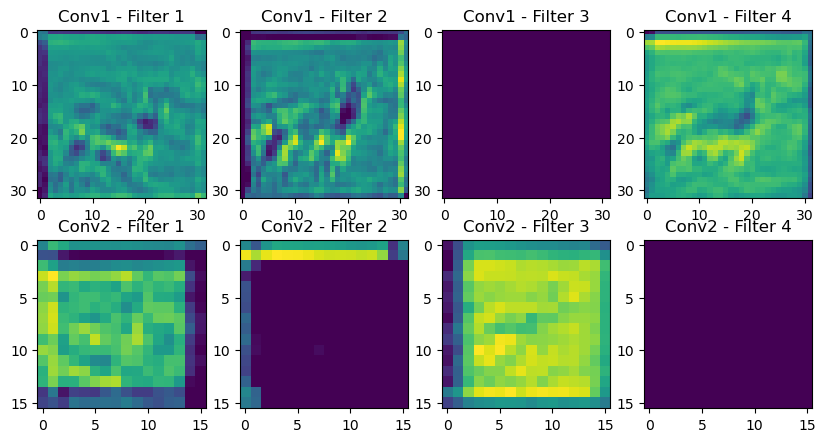

Epoch 8, Train Accuracy: 0.10, Test Accuracy: 0.10


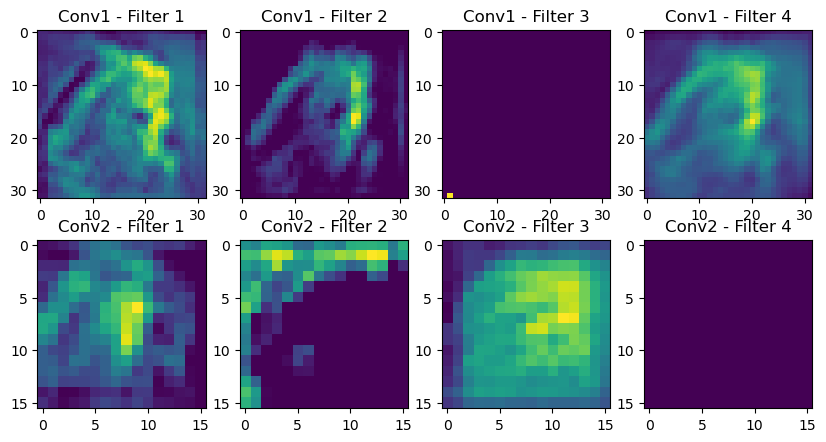

Epoch 9, Train Accuracy: 0.10, Test Accuracy: 0.10


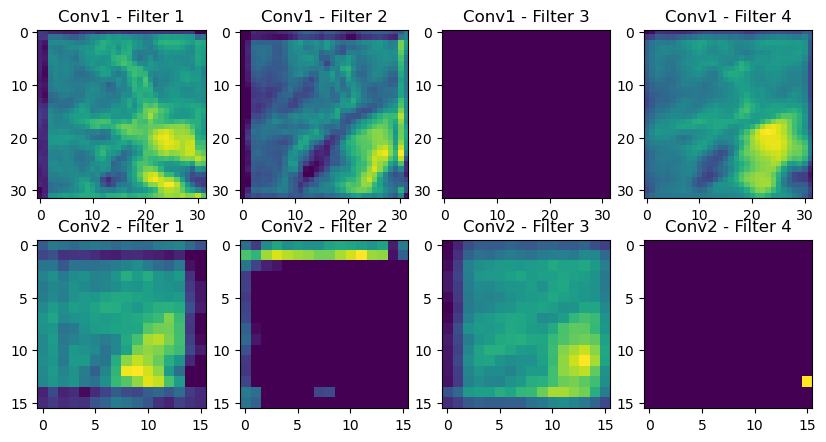

Epoch 10, Train Accuracy: 0.09, Test Accuracy: 0.10


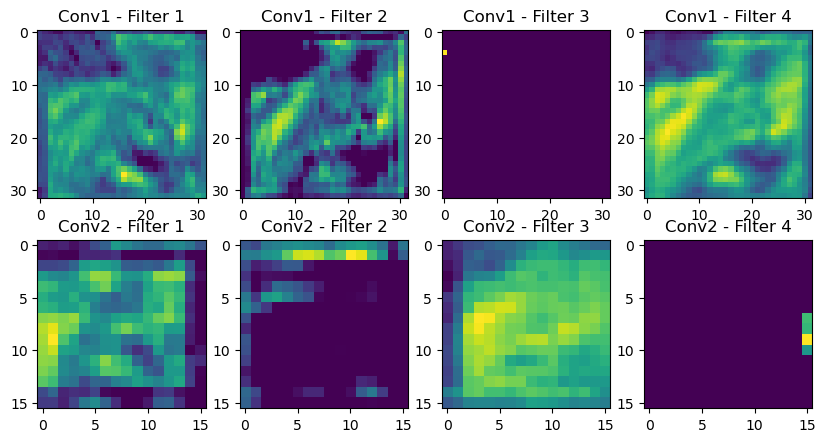

Epoch 11, Train Accuracy: 0.10, Test Accuracy: 0.09


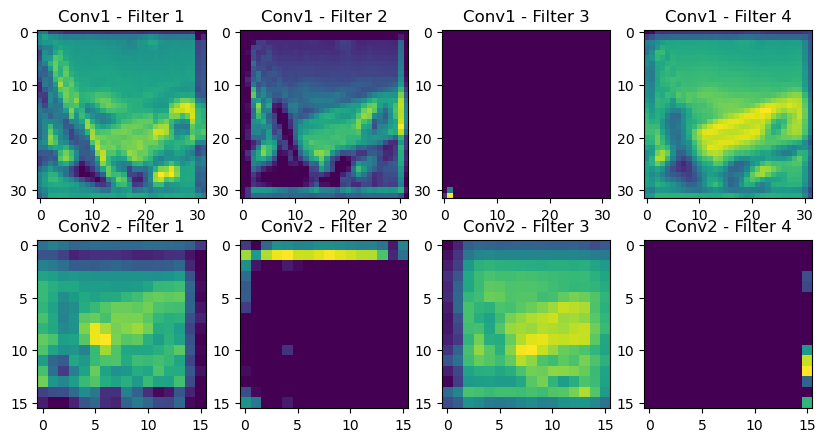

Epoch 12, Train Accuracy: 0.10, Test Accuracy: 0.09


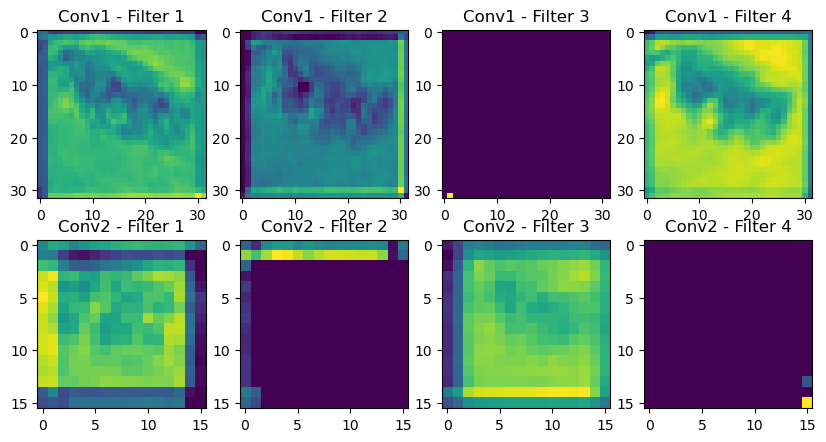

Epoch 13, Train Accuracy: 0.10, Test Accuracy: 0.09


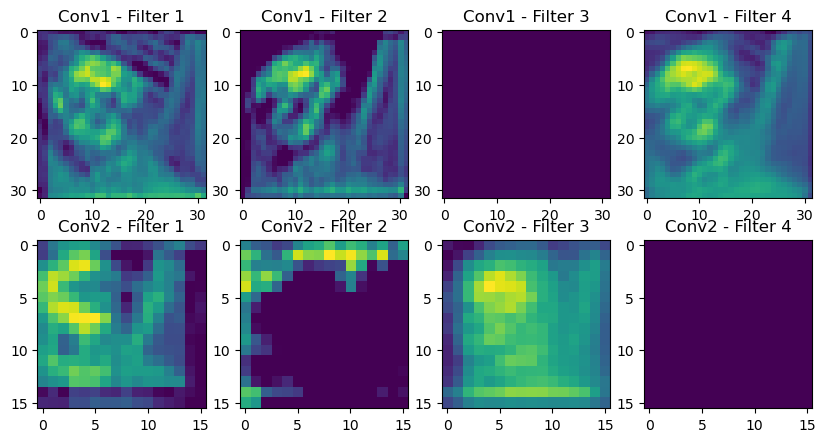

Epoch 14, Train Accuracy: 0.10, Test Accuracy: 0.09


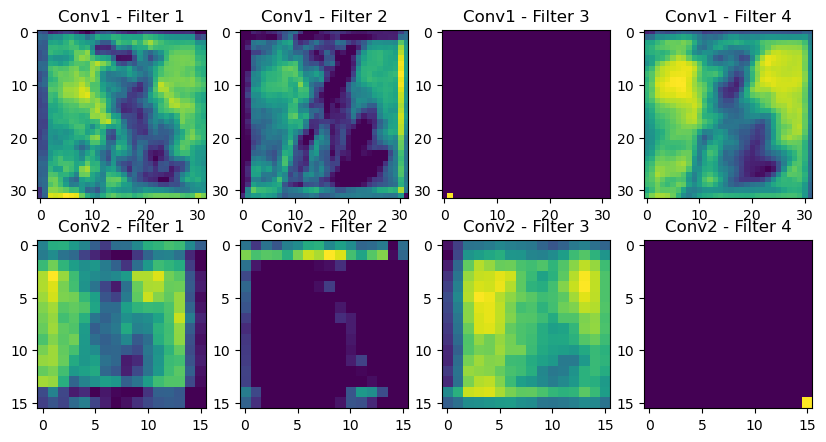

Epoch 15, Train Accuracy: 0.10, Test Accuracy: 0.09


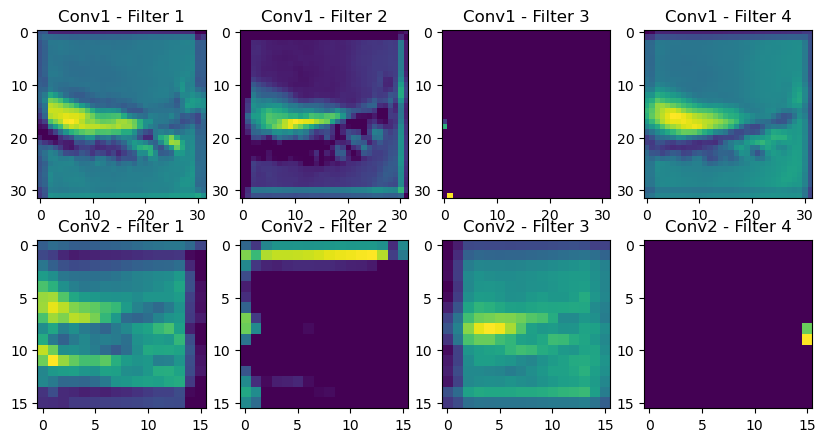

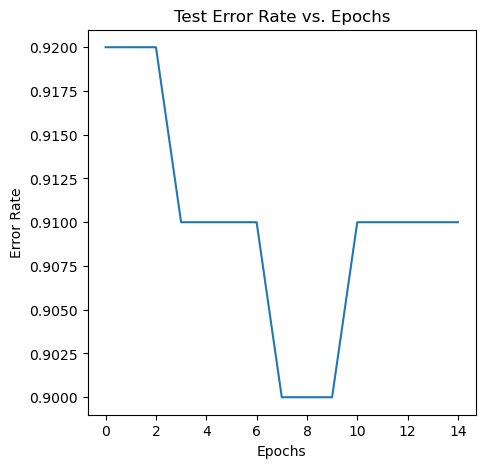

In [19]:
model = CNN()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001)

print("Training with Vanilla SGD")
train_model(model, X_train, Y_train, X_test, Y_test, optimizer_sgd, batch_size=8, num_epochs=15)

Training with SGD + Momentum


/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 2, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 3, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 4, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 5, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 6, Train Accuracy: 0.14, Test Accuracy: 0.12
Epoch 7, Train Accuracy: 0.15, Test Accuracy: 0.12
Epoch 8, Train Accuracy: 0.13, Test Accuracy: 0.10
Epoch 9, Train Accuracy: 0.12, Test Accuracy: 0.10
Epoch 10, Train Accuracy: 0.17, Test Accuracy: 0.11
Epoch 11, Train Accuracy: 0.17, Test Accuracy: 0.10
Epoch 12, Train Accuracy: 0.17, Test Accuracy: 0.06
Epoch 13, Train Accuracy: 0.19, Test Accuracy: 0.10
Epoch 14, Train Accuracy: 0.21, Test Accuracy: 0.08
Epoch 15, Train Accuracy: 0.25, Test Accuracy: 0.12
Epoch 16, Train Accuracy: 0.29, Test Accuracy: 0.13
Epoch 17, Train Accuracy: 0.29, Test Accuracy: 0.14
Epoch 18, Train Accuracy: 0.26, Test Accuracy: 0.15
Epoch 19, Train Accuracy: 0.28, Test Accuracy: 0.14
Epoch 20, Train Accur

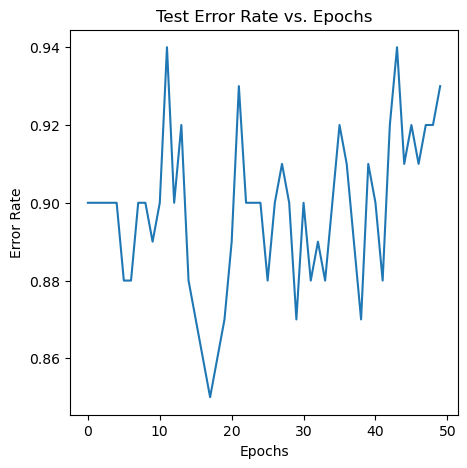

In [20]:
model = CNN()
optimizer_momentum = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("Training with SGD + Momentum")
train_model(model, X_train, Y_train, X_test, Y_test, optimizer_momentum, num_epochs=50, display_activation_maps=False)

Training with RMSProp


/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 2, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 3, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 4, Train Accuracy: 0.20, Test Accuracy: 0.10
Epoch 5, Train Accuracy: 0.26, Test Accuracy: 0.15
Epoch 6, Train Accuracy: 0.32, Test Accuracy: 0.14
Epoch 7, Train Accuracy: 0.33, Test Accuracy: 0.16
Epoch 8, Train Accuracy: 0.35, Test Accuracy: 0.11
Epoch 9, Train Accuracy: 0.37, Test Accuracy: 0.13
Epoch 10, Train Accuracy: 0.40, Test Accuracy: 0.09
Epoch 11, Train Accuracy: 0.38, Test Accuracy: 0.10
Epoch 12, Train Accuracy: 0.40, Test Accuracy: 0.09
Epoch 13, Train Accuracy: 0.44, Test Accuracy: 0.10
Epoch 14, Train Accuracy: 0.47, Test Accuracy: 0.09
Epoch 15, Train Accuracy: 0.40, Test Accuracy: 0.10
Epoch 16, Train Accuracy: 0.50, Test Accuracy: 0.06
Epoch 17, Train Accuracy: 0.50, Test Accuracy: 0.08
Epoch 18, Train Accuracy: 0.48, Test Accuracy: 0.10
Epoch 19, Train Accuracy: 0.51, Test Accuracy: 0.10
Epoch 20, Train Accur

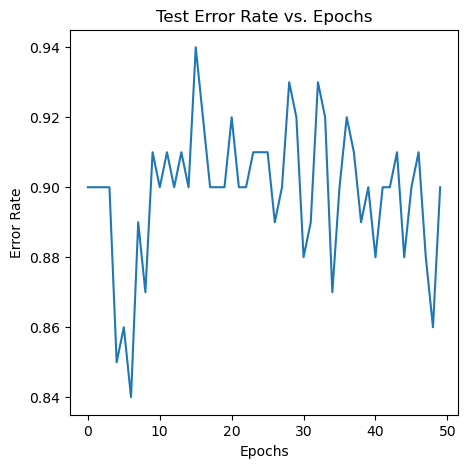

In [21]:
model = CNN()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

print("Training with RMSProp")
train_model(model, X_train, Y_train, X_test, Y_test, optimizer_rmsprop, num_epochs=50, display_activation_maps=False)

4\)

In [22]:
from sklearn.manifold import TSNE

In [23]:
# Function to get bottleneck features from the model
def get_bottleneck_features(model, X_train):
    model.eval()
    train_features = []
    train_labels = []

    with torch.no_grad():
        for i, inputs in enumerate(X_train):
            inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
            outputs = model.conv1(inputs)
            outputs = model.pool(outputs)
            outputs = model.conv2(outputs)
            outputs = model.pool(outputs)
            outputs = flatten(outputs)
            train_features.append(outputs.numpy())
            train_labels.append(Y_train[i])
    
    return np.array(train_features), np.array(train_labels)

In [24]:
def visualize_tsne(features, labels, epoch):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    for class_id in range(10):
        indices = [i for i, label in enumerate(labels) if label == class_id]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], label=f'Class {class_id}')
    plt.legend()
    plt.title(f"t-SNE Visualization of Bottleneck Layer Outputs (Epoch {epoch})")
    plt.show()

For Vanilla SGD

/tmp/ipykernel_9899/4128872029.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


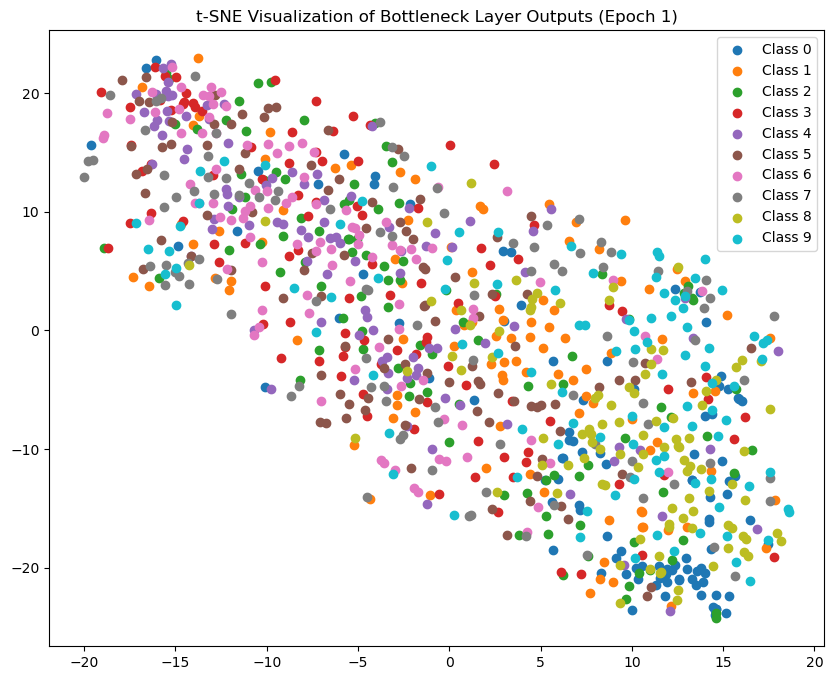

/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 2, Train Accuracy: 0.10, Test Accuracy: 0.09
Epoch 3, Train Accuracy: 0.10, Test Accuracy: 0.08
Epoch 4, Train Accuracy: 0.10, Test Accuracy: 0.08
Epoch 5, Train Accuracy: 0.10, Test Accuracy: 0.08
Epoch 6, Train Accuracy: 0.10, Test Accuracy: 0.08
Epoch 7, Train Accuracy: 0.11, Test Accuracy: 0.09
Epoch 8, Train Accuracy: 0.11, Test Accuracy: 0.11
Epoch 9, Train Accuracy: 0.11, Test Accuracy: 0.11
Epoch 10, Train Accuracy: 0.11, Test Accuracy: 0.11
Epoch 11, Train Accuracy: 0.12, Test Accuracy: 0.11
Epoch 12, Train Accuracy: 0.11, Test Accuracy: 0.12
Epoch 13, Train Accuracy: 0.11, Test Accuracy: 0.12
Epoch 14, Train Accuracy: 0.12, Test Accuracy: 0.12
Epoch 15, Train Accuracy: 0.12, Test Accuracy: 0.12
Epoch 16, Train Accuracy: 0.11, Test Accuracy: 0.12
Epoch 17, Train Accuracy: 0.11, Test Accuracy: 0.12
Epoch 18, Train Accuracy: 0.11, Test Accuracy: 0.12
Epoch 19, Train Accuracy: 0.11, Test Accuracy: 0.12
Epoch 20, Train Accur

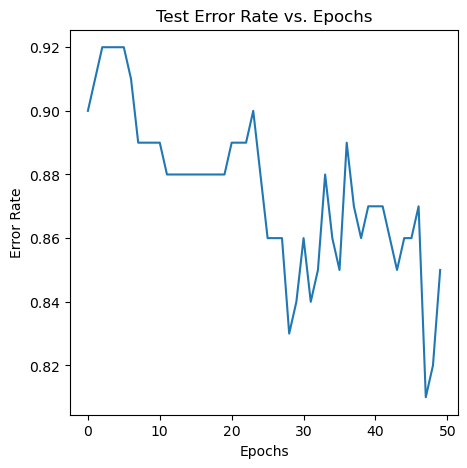

/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


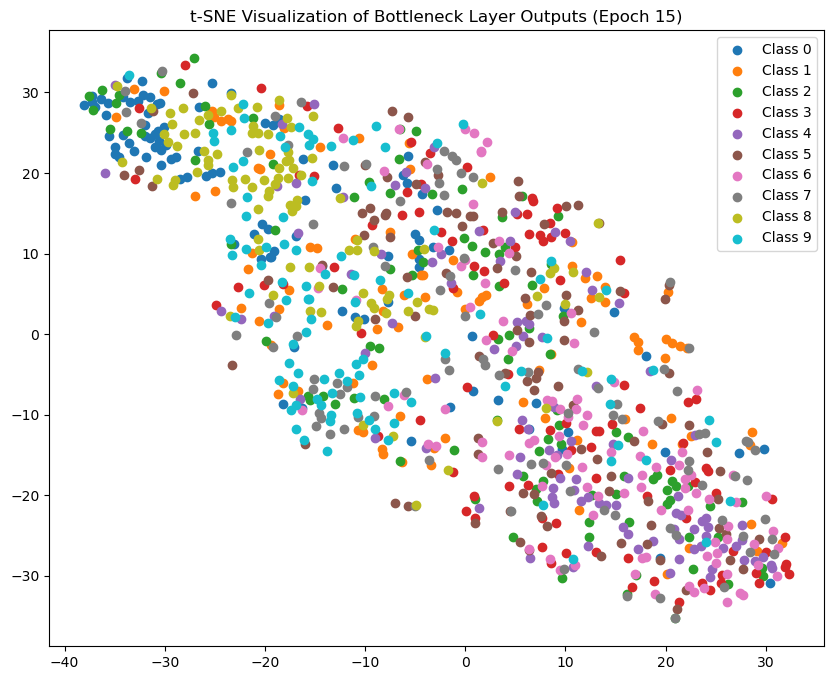

In [25]:
model = CNN()

# Visualize the t-SNE plot for the first epoch
features_first_epoch, labels = get_bottleneck_features(model, X_train)
visualize_tsne(features_first_epoch, labels, epoch=1)

# Train the model for 15 epochs and visualize the t-SNE plot for the last epoch
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001)
train_model(model, X_train, Y_train, X_test, Y_test, optimizer_sgd, num_epochs=50, display_activation_maps=False)

features_last_epoch, labels = get_bottleneck_features(model, X_train)
visualize_tsne(features_last_epoch, labels, epoch=15)

For SGD with momentum

/tmp/ipykernel_9899/4128872029.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


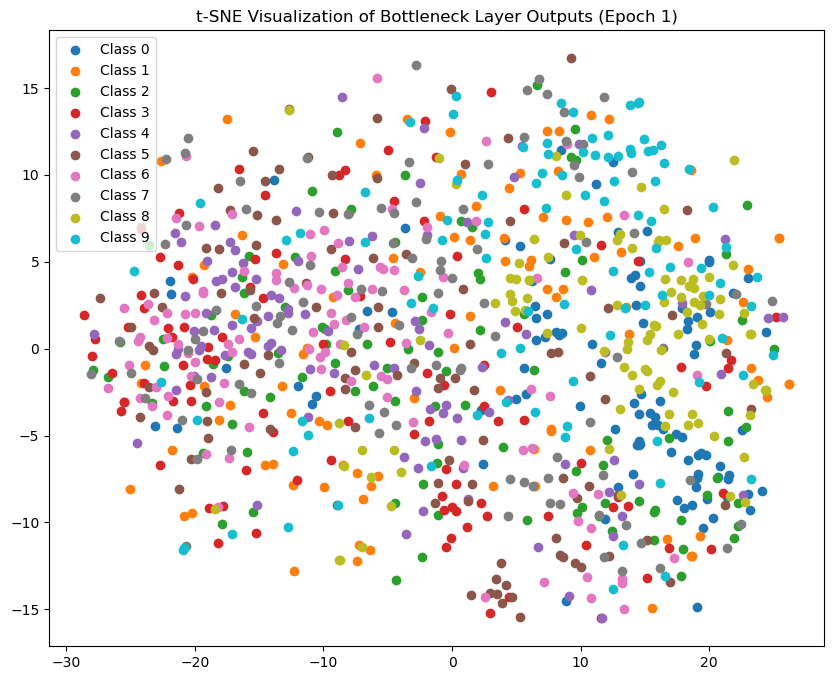

/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 2, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 3, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 4, Train Accuracy: 0.14, Test Accuracy: 0.07
Epoch 5, Train Accuracy: 0.11, Test Accuracy: 0.09
Epoch 6, Train Accuracy: 0.19, Test Accuracy: 0.12
Epoch 7, Train Accuracy: 0.22, Test Accuracy: 0.12
Epoch 8, Train Accuracy: 0.25, Test Accuracy: 0.12
Epoch 9, Train Accuracy: 0.30, Test Accuracy: 0.12
Epoch 10, Train Accuracy: 0.29, Test Accuracy: 0.11
Epoch 11, Train Accuracy: 0.30, Test Accuracy: 0.11
Epoch 12, Train Accuracy: 0.33, Test Accuracy: 0.15
Epoch 13, Train Accuracy: 0.31, Test Accuracy: 0.14
Epoch 14, Train Accuracy: 0.36, Test Accuracy: 0.10
Epoch 15, Train Accuracy: 0.36, Test Accuracy: 0.11
Epoch 16, Train Accuracy: 0.36, Test Accuracy: 0.09
Epoch 17, Train Accuracy: 0.36, Test Accuracy: 0.10
Epoch 18, Train Accuracy: 0.42, Test Accuracy: 0.11
Epoch 19, Train Accuracy: 0.35, Test Accuracy: 0.08
Epoch 20, Train Accur

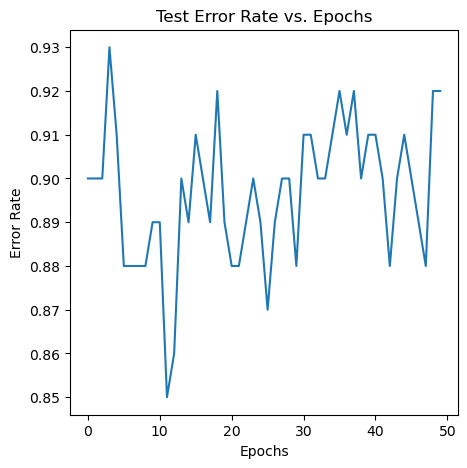

/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


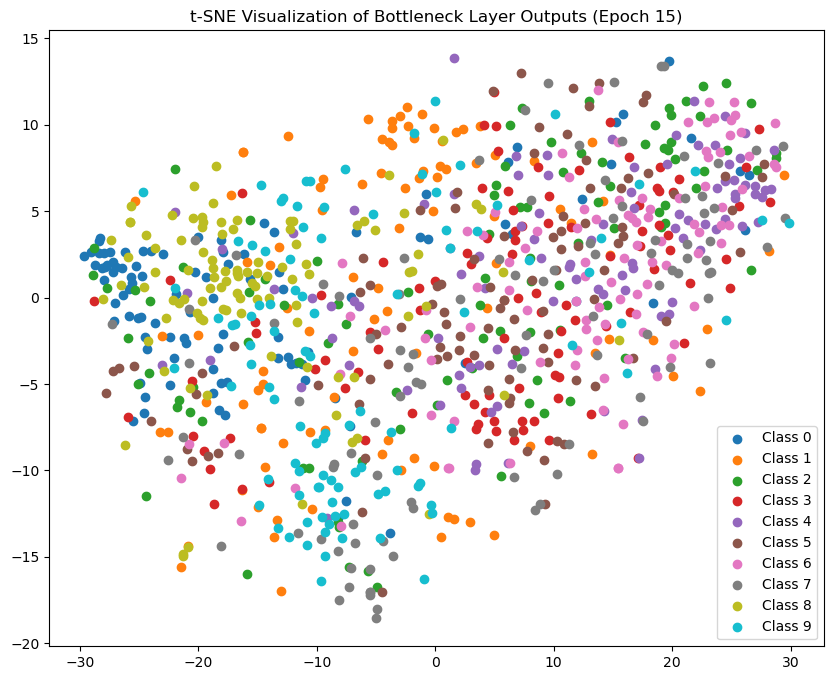

In [26]:
model = CNN()

# Visualize the t-SNE plot for the first epoch
features_first_epoch, labels = get_bottleneck_features(model, X_train)
visualize_tsne(features_first_epoch, labels, epoch=1)

# Train the model for 15 epochs and visualize the t-SNE plot for the last epoch
optimizer_momentum = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model(model, X_train, Y_train, X_test, Y_test, optimizer_momentum, num_epochs=50, display_activation_maps=False)

features_last_epoch, labels = get_bottleneck_features(model, X_train)
visualize_tsne(features_last_epoch, labels, epoch=15)

For RMSprop

/tmp/ipykernel_9899/4128872029.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


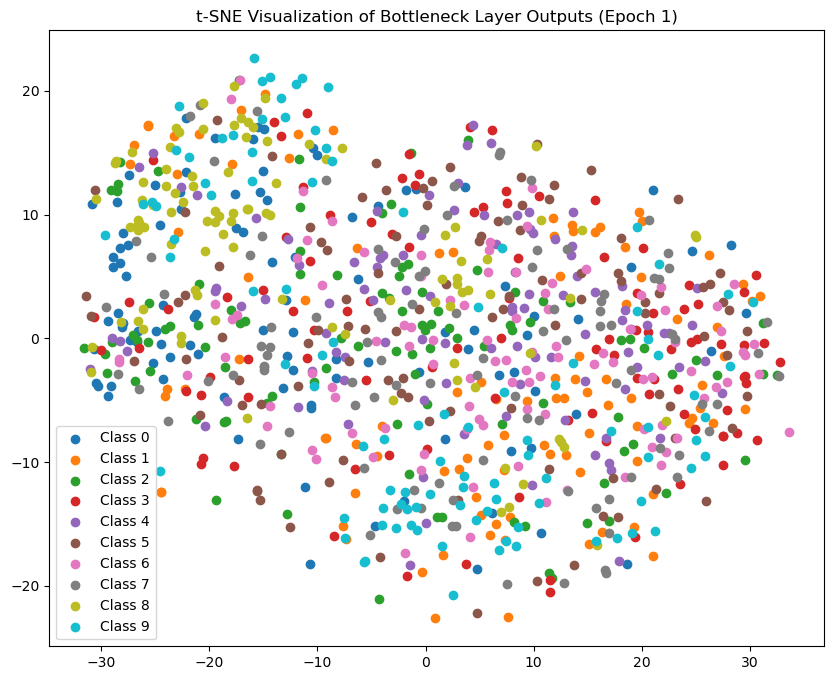

/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 2, Train Accuracy: 0.19, Test Accuracy: 0.14
Epoch 3, Train Accuracy: 0.28, Test Accuracy: 0.12
Epoch 4, Train Accuracy: 0.28, Test Accuracy: 0.15
Epoch 5, Train Accuracy: 0.32, Test Accuracy: 0.14
Epoch 6, Train Accuracy: 0.34, Test Accuracy: 0.14
Epoch 7, Train Accuracy: 0.40, Test Accuracy: 0.11
Epoch 8, Train Accuracy: 0.42, Test Accuracy: 0.10
Epoch 9, Train Accuracy: 0.45, Test Accuracy: 0.07
Epoch 10, Train Accuracy: 0.44, Test Accuracy: 0.08
Epoch 11, Train Accuracy: 0.50, Test Accuracy: 0.09
Epoch 12, Train Accuracy: 0.46, Test Accuracy: 0.09
Epoch 13, Train Accuracy: 0.50, Test Accuracy: 0.12
Epoch 14, Train Accuracy: 0.54, Test Accuracy: 0.13
Epoch 15, Train Accuracy: 0.58, Test Accuracy: 0.10
Epoch 16, Train Accuracy: 0.57, Test Accuracy: 0.12
Epoch 17, Train Accuracy: 0.61, Test Accuracy: 0.12
Epoch 18, Train Accuracy: 0.59, Test Accuracy: 0.11
Epoch 19, Train Accuracy: 0.57, Test Accuracy: 0.09
Epoch 20, Train Accur

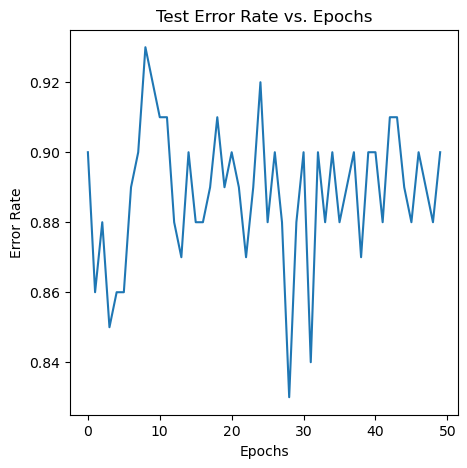

/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aayush_kumar/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


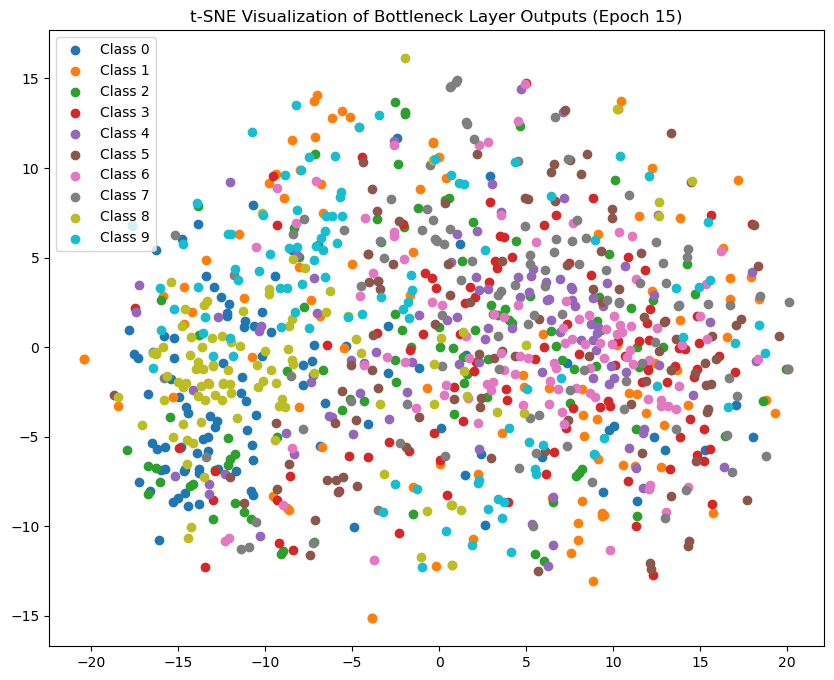

In [27]:
model = CNN()

# Visualize the t-SNE plot for the first epoch
features_first_epoch, labels = get_bottleneck_features(model, X_train)
visualize_tsne(features_first_epoch, labels, epoch=1)

# Train the model for 15 epochs and visualize the t-SNE plot for the last epoch
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
train_model(model, X_train, Y_train, X_test, Y_test, optimizer_rmsprop, num_epochs=50, display_activation_maps=False)

features_last_epoch, labels = get_bottleneck_features(model, X_train)
visualize_tsne(features_last_epoch, labels, epoch=15)

5\)

In [35]:
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate):
        super(CNNWithDropout, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=2)

        # First Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)

        # First Fully Connected Layer with 49 nodes
        self.fc1 = nn.Linear(4 * 8 * 8, 49)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)

        # Output Layer with 10 nodes (for each class)
        self.fc2 = nn.Linear(49, 10)

    def forward(self, x):
        # First Convolutional Layer
        x = self.conv1(x)
        x = nn.ReLU()(x)

        # First Pooling Layer
        x = self.pool(x)

        # Second Convolutional Layer
        x = self.conv2(x)
        x = nn.ReLU()(x)

        # Second Pooling Layer
        x = self.pool(x)

        # Flatten the output volume
        x = x.view(-1, 4 * 8 * 8)

        # First Fully Connected Layer
        x = self.fc1(x)
        x = nn.ReLU()(x)

        # Dropout Layer
        x = self.dropout(x)

        # Output Layer, no activation function (will be applied later)
        x = self.fc2(x)

        return x


Training with Dropout rate = 0.2


/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.08, Test Accuracy: 0.11
Epoch 2, Train Accuracy: 0.13, Test Accuracy: 0.10
Epoch 3, Train Accuracy: 0.17, Test Accuracy: 0.09
Epoch 4, Train Accuracy: 0.31, Test Accuracy: 0.14
Epoch 5, Train Accuracy: 0.33, Test Accuracy: 0.09
Epoch 6, Train Accuracy: 0.37, Test Accuracy: 0.12
Epoch 7, Train Accuracy: 0.41, Test Accuracy: 0.10
Epoch 8, Train Accuracy: 0.45, Test Accuracy: 0.11
Epoch 9, Train Accuracy: 0.48, Test Accuracy: 0.10
Epoch 10, Train Accuracy: 0.41, Test Accuracy: 0.07
Epoch 11, Train Accuracy: 0.48, Test Accuracy: 0.11
Epoch 12, Train Accuracy: 0.50, Test Accuracy: 0.12
Epoch 13, Train Accuracy: 0.55, Test Accuracy: 0.12
Epoch 14, Train Accuracy: 0.57, Test Accuracy: 0.10
Epoch 15, Train Accuracy: 0.60, Test Accuracy: 0.10
Epoch 16, Train Accuracy: 0.60, Test Accuracy: 0.11
Epoch 17, Train Accuracy: 0.61, Test Accuracy: 0.15
Epoch 18, Train Accuracy: 0.62, Test Accuracy: 0.10
Epoch 19, Train Accuracy: 0.66, Test Accuracy: 0.10
Epoch 20, Train Accur

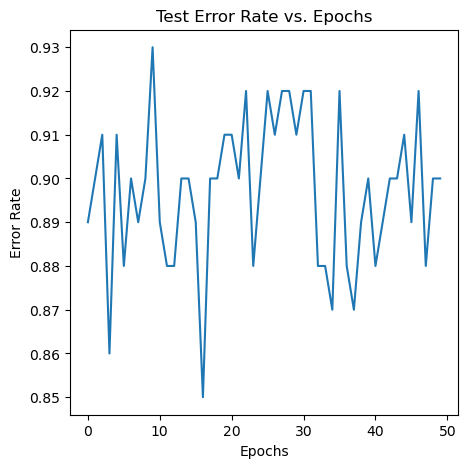

Final Accuracy: 0.1

Training with Dropout rate = 0.5
Epoch 1, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 2, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 3, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 4, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 5, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 6, Train Accuracy: 0.10, Test Accuracy: 0.10
Epoch 7, Train Accuracy: 0.13, Test Accuracy: 0.10
Epoch 8, Train Accuracy: 0.24, Test Accuracy: 0.19
Epoch 9, Train Accuracy: 0.27, Test Accuracy: 0.17
Epoch 10, Train Accuracy: 0.27, Test Accuracy: 0.14
Epoch 11, Train Accuracy: 0.27, Test Accuracy: 0.13
Epoch 12, Train Accuracy: 0.31, Test Accuracy: 0.16
Epoch 13, Train Accuracy: 0.27, Test Accuracy: 0.12
Epoch 14, Train Accuracy: 0.32, Test Accuracy: 0.13
Epoch 15, Train Accuracy: 0.32, Test Accuracy: 0.13
Epoch 16, Train Accuracy: 0.27, Test Accuracy: 0.09
Epoch 17, Train Accuracy: 0.34, Test Accuracy: 0.12
Epoch 18, Train Accuracy: 0.34, Test Accuracy: 0.17
Epoch 19, Train Acc

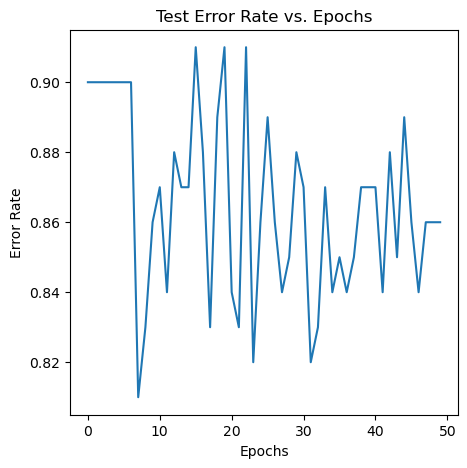

Final Accuracy: 0.14

Training with Dropout rate = 0.8
Epoch 1, Train Accuracy: 0.10, Test Accuracy: 0.07
Epoch 2, Train Accuracy: 0.09, Test Accuracy: 0.12
Epoch 3, Train Accuracy: 0.14, Test Accuracy: 0.12
Epoch 4, Train Accuracy: 0.14, Test Accuracy: 0.10
Epoch 5, Train Accuracy: 0.20, Test Accuracy: 0.11
Epoch 6, Train Accuracy: 0.22, Test Accuracy: 0.17
Epoch 7, Train Accuracy: 0.23, Test Accuracy: 0.18
Epoch 8, Train Accuracy: 0.28, Test Accuracy: 0.19
Epoch 9, Train Accuracy: 0.19, Test Accuracy: 0.11
Epoch 10, Train Accuracy: 0.26, Test Accuracy: 0.19
Epoch 11, Train Accuracy: 0.30, Test Accuracy: 0.19
Epoch 12, Train Accuracy: 0.29, Test Accuracy: 0.18
Epoch 13, Train Accuracy: 0.31, Test Accuracy: 0.17
Epoch 14, Train Accuracy: 0.26, Test Accuracy: 0.12
Epoch 15, Train Accuracy: 0.28, Test Accuracy: 0.16
Epoch 16, Train Accuracy: 0.29, Test Accuracy: 0.19
Epoch 17, Train Accuracy: 0.26, Test Accuracy: 0.12
Epoch 18, Train Accuracy: 0.28, Test Accuracy: 0.20
Epoch 19, Train Ac

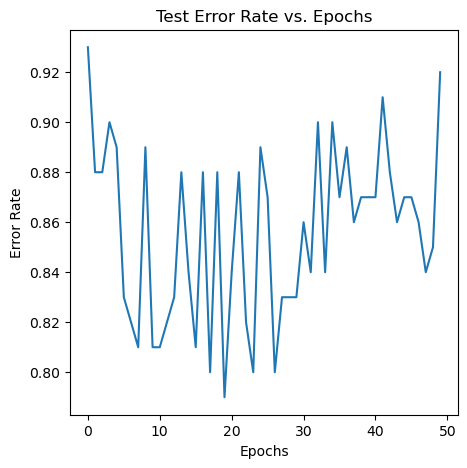

Final Accuracy: 0.08


In [36]:
dropout_rates = [0.2, 0.5, 0.8]
for rate in dropout_rates:
    print(f"\nTraining with Dropout rate = {rate}")
    model = CNNWithDropout(dropout_rate=rate)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
    train_model(model, X_train, Y_train, X_test, Y_test, optimizer, num_epochs=50, display_activation_maps=False)
    acc = accuracy(model, X_test, Y_test)
    print(f"Final Accuracy: {acc}")

On using dropout, the accuracy on training set is increased significantly compared to the model without dropout. But the test error 
increases only slightly for only some values of dropout rate.

On increasing the dropout rate, the accuracy on training set decreases.

6\)

In [37]:
class CNNWithBNAndDropout(nn.Module):
    def __init__(self, dropout_rate):
        super(CNNWithBNAndDropout, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=2)

        # First Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)

        # First Fully Connected Layer with 49 nodes
        self.fc1 = nn.Linear(4 * 8 * 8, 49)

        # Batch Normalization Layer
        self.bn1 = nn.BatchNorm1d(49)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)

        # Output Layer with 10 nodes (for each class)
        self.fc2 = nn.Linear(49, 10)

    def forward(self, x):
        # First Convolutional Layer
        x = self.conv1(x)
        x = nn.ReLU()(x)

        # First Pooling Layer
        x = self.pool(x)

        # Second Convolutional Layer
        x = self.conv2(x)
        x = nn.ReLU()(x)

        # Second Pooling Layer
        x = self.pool(x)

        # Flatten the output volume
        x = x.view(-1, 4 * 8 * 8)

        # First Fully Connected Layer
        x = self.fc1(x)
        x = nn.ReLU()(x)

        # Batch Normalization Layer
        x = self.bn1(x)

        # Dropout Layer
        x = self.dropout(x)

        # Output Layer, no activation function (will be applied later)
        x = self.fc2(x)

        return x


Training with Batch Normalization and Dropout rate = 0.2


/tmp/ipykernel_9899/3999393803.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(batch_inputs, dtype=torch.float32).reshape(batch_inputs.shape[0], 3, 32, 32)
/tmp/ipykernel_9899/3999393803.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch_labels, dtype=torch.long).reshape(batch_labels.shape[0])
/tmp/ipykernel_9899/1406087342.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).reshape(1, 3, 32, 32)
/tmp/ipykernel_9899/140

Epoch 1, Train Accuracy: 0.07, Test Accuracy: 0.08
Epoch 2, Train Accuracy: 0.22, Test Accuracy: 0.12
Epoch 3, Train Accuracy: 0.23, Test Accuracy: 0.09
Epoch 4, Train Accuracy: 0.30, Test Accuracy: 0.15
Epoch 5, Train Accuracy: 0.29, Test Accuracy: 0.15
Epoch 6, Train Accuracy: 0.34, Test Accuracy: 0.13
Epoch 7, Train Accuracy: 0.40, Test Accuracy: 0.14
Epoch 8, Train Accuracy: 0.39, Test Accuracy: 0.09
Epoch 9, Train Accuracy: 0.15, Test Accuracy: 0.09
Epoch 10, Train Accuracy: 0.32, Test Accuracy: 0.15
Epoch 11, Train Accuracy: 0.50, Test Accuracy: 0.14
Epoch 12, Train Accuracy: 0.43, Test Accuracy: 0.11
Epoch 13, Train Accuracy: 0.52, Test Accuracy: 0.11
Epoch 14, Train Accuracy: 0.43, Test Accuracy: 0.10
Epoch 15, Train Accuracy: 0.50, Test Accuracy: 0.13
Epoch 16, Train Accuracy: 0.54, Test Accuracy: 0.15
Epoch 17, Train Accuracy: 0.55, Test Accuracy: 0.12
Epoch 18, Train Accuracy: 0.51, Test Accuracy: 0.10
Epoch 19, Train Accuracy: 0.49, Test Accuracy: 0.09
Epoch 20, Train Accur

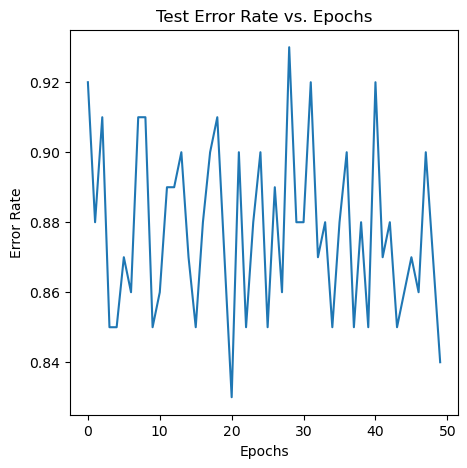

Final Accuracy: 0.16


In [40]:
print("\nTraining with Batch Normalization and Dropout rate = 0.2")
model = CNNWithBNAndDropout(dropout_rate=0.2)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
train_model(model, X_train, Y_train, X_test, Y_test, optimizer, num_epochs=50, display_activation_maps=False)
acc = accuracy(model, X_test, Y_test)
print(f"Final Accuracy: {acc}")

On using Batch Normalization and Dropout, the accuracy on test set is slightly better than the model with only dropout and the model without dropout.